In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
connect = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create inspector avenue
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get table column names
columns1 = inspector.get_columns('measurement')
for column in columns1:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns2 = inspector.get_columns('station')
for column in columns2:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [13]:
import datetime as dt

In [14]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

('2017-08-23',)


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [16]:
# Calculate the date one year from the last date in data set.
stop_query_date = dt.datetime(2017,8,23) - dt.timedelta(days = 365)
print(stop_query_date)

2016-08-23 00:00:00


In [41]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= dt.date(2016,8,23)).\
    filter(Measurement.date <= dt.date(2017,8,23)).\
    order_by(Measurement.date).all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_rows = [{"Date": rain[0],'Precipitation': rain[1]} for rain in precipitation]
prcp_rows

# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_rows).set_index("Date")
prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


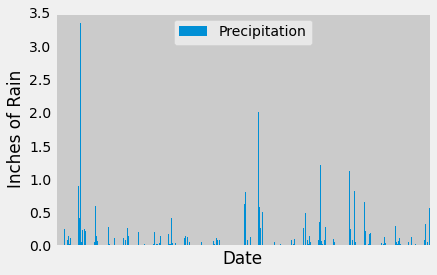

In [194]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.bar()
plt.xlabel('Date')
plt.ylabel('Inches of Rain')
plt.style.use('fivethirtyeight')
plt.ylim(0,3.5)
plt.xticks(rotation = 90, horizontalalignment = 'center')
plt.tick_params(labelbottom=False)
plt.show()

In [23]:
prcp_df.reset_index()
prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
quartiles = prcp_df['Precipitation'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
count = prcp_df['Precipitation'].count()
mean = prcp_df['Precipitation'].mean()
minimum = prcp_df['Precipitation'].min()
maximum = prcp_df['Precipitation'].max()
std = prcp_df['Precipitation'].std()

print("Summary Statistics")
print("-------------------")
print(f"Count: {count}")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Min: {minimum}")
print(f"Lower Quartile (25%): {lowerq}")
print(f"Upper Quartile (75%): {upperq}")
print(f"Max: {maximum}")

Summary Statistics
-------------------
Count: 2021
Mean: 0.17727857496288896
Standard Deviation: 0.4611895038877027
Min: 0.0
Lower Quartile (25%): 0.0
Upper Quartile (75%): 0.13
Max: 6.7


# Exploratory Station Analysis

In [170]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).group_by(Station.station).count()
print(f"There are {total_stations} total stations.")

There are 9 total stations.


In [209]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,
       func.count(Measurement.station)]
active = session.query(*sel).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).limit(5).all()
print(active)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612)]


In [235]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_one = 'USC00519281'

sel = [Measurement.station,
       func.count(Measurement.station),
       func.avg(Measurement.tobs),
       func.max(Measurement.tobs),
       func.min(Measurement.tobs)]

top1 = session.query(*sel).group_by(Measurement.station).\
    filter(Measurement.station == station_one).all()
print(top1)

[('USC00519281', 2772, 71.66378066378067, 85.0, 54.0)]


In [244]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station,
      Measurement.tobs]

temperature = session.query(*sel).\
    filter(Measurement.date >= dt.date(2016,8,23)).\
    filter(Measurement.date <= dt.date(2017,8,23)).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date).all()

In [253]:
temp_rows = [{"Station": temp[0],'Precipitation': temp[1]} for temp in temperature]
temp_rows

# Sort the dataframe by date
temp_df = pd.DataFrame(temp_rows).set_index("Station")
temp_df

,Precipitation
Station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
...,...
USC00519281,77.0
USC00519281,77.0
USC00519281,76.0


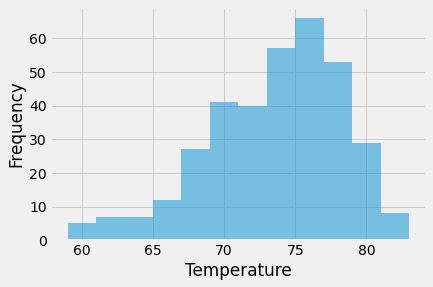

In [270]:
plt.hist(temp_df, bins=12, alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.style.use('fivethirtyeight')

# Close session

In [42]:
# Close Session
session.close()